### Aluno: Wesley Wevertton de Azevedo Palmeira - 201621250039
### Disciplina: Sinais e Sistemas


### TAREFA 1: Reproduzir e explicar os resultados do artigo do <a href='https://dspillustrations.com/pages/posts/misc/the-sound-of-harmonics-approximating-instrument-sounds-with-fourier-series.html'>link 2</a>, considerando ao menos três amostrasde som disponíveis neste site.

#### No <a href='https://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html'>link 1</a>,  foi mostrado como diferentes números de harmonicas se aproximam de funções períodas artificiais. O objetivo agora, é considerar um período de um som de um instrumento (no nosso caso alguns sons de flautas, considerando ainda que o som tocado seja períodico), expandir sua forma de onda em seno e cossenos de frequências harmônicas e, reconstruir o sinal original a partir dele.

In [148]:
def fourierSeries(period, N):
    """Cálculo dos coeficientes da série de fourier até o n-ésimo harmônico"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

#### A função definida como fourierSeries tem o objetivo de calcular os coeficientes da série de fourier até a n-ésima harmônica em forma de seno e cossenos 

In [149]:
def reconstruct(P, anbn):
    """Soma os senos e cossenos de acordo com os coeficientes para reconstruir a onda original"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

#### A função definida como reconstruct tem o objetivo de somas os senos e cossenos de acordo com os coeficientes da serie de fourrier e construir a forma de onde original

In [150]:
from scipy.io import wavfile
import requests
from io import BytesIO
from IPython.display import Audio
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # Para Sons Stereo, estou considerando apenas usar um canal de audio
        data = data[:,0]
    return data, rate

# A URL dos sons WAV, note que o site é diferente do proposto no documento do projeto, isso foi acordado com o professor 
# via whatsapp, os sons são os sons de 3 flautes de diferentes timbres, os sons aparentam ser constantes, logo são periodicos
urls = ["https://freewavesamples.com/files/Alesis-Fusion-Shakuhachi-C5.wav",
       "https://freewavesamples.com/files/E-Mu-Proteus-FX-Ocarina-C5.wav",
       "https://freewavesamples.com/files/Korg-M3R-Pan-Pipes-C5.wav"]
sounds = []
for url in urls:
    sound, rate = loadSound(url)
    sounds.append((sound, rate))

#### A função loadSound tem o objetivo de carregar os sons das ondas a serem analisadas.

In [151]:
# Esta função foi criada apenas para printar os sons um ao lado do outro no jupyter notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '%s %s \n %s %s' % (name1, audio1._repr_html_(), name2, audio2._repr_html_())
    display(HTML(text))

In [152]:
from IPython.core.display import HTML
#Este trecho de código mostra os sons que foram "baixados" no jupyter notebook.
for n, s in enumerate(sounds):
    display(HTML("Som de flauta %d" % (n+1) + Audio(data=s[0], rate=s[1])._repr_html_()))

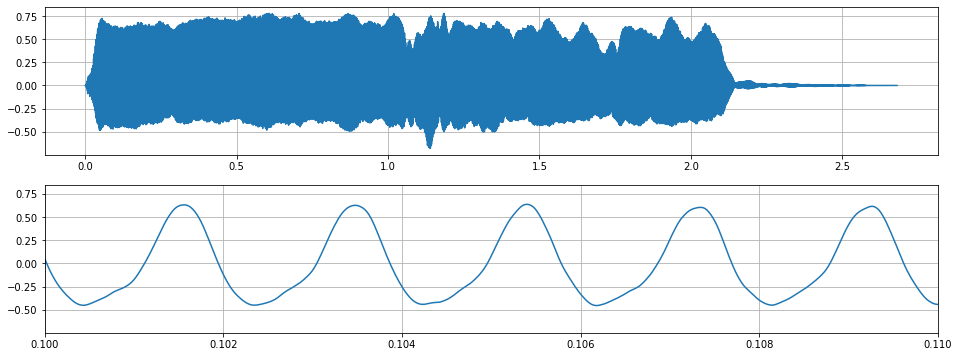

In [153]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.figure(figsize=(16, 6))
plt.subplot(211)
plt.grid(True)
plt.plot(t, sounds[0][0])
plt.subplot(212)
plt.grid(True)
plt.xlim(0.1,0.11)
plt.plot(t, sounds[0][0])

#### Olhando para a primeira figura a gente não consegue ver nenhuma periodicidade, mas olhando para a segunda (uma versão ampliada da primeira) podemos perceber que se trata sim de um sinal periodico bem definido.

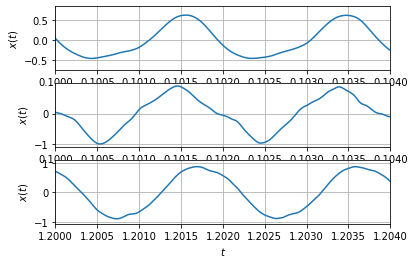

In [154]:
def extractPeriod(data, rate, t_start, t_end):
    if(t_start == 0.1):
        plt.xlim(0.100,0.104)
    else:
        plt.xlim(1.200,1.204)
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)
    plt.grid(True)
    duration = t_end - t_start
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');


    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Som original", Audio(data=data,rate=rate),
                    "Som do período extraído", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

periods = []
rates = []
# Manualmente foi encontrado o início e o fim do período de cada sinal, isso foi feito observando a forma de onda e
# também escutando a som do período extraído.
periodBounds = [(0.100,0.102),
                (0.100,0.102),
                (1.200,1.202)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)

#### Em um primeiro momento podemos ver cada som e seu período extraído lado a lado, podemos perceber que a repetição do período extraído se aproxima muito do som original. No segundo momento podemos ver os gráficos relativos a dois períodos, para firmar ainda mais a periodicidade do sinal.

In [155]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    plt.figure()
    plt.subplot(121)
    plt.grid(True)
    plt.plot(t*1000, period, label='Som original') 
    plt.plot(t*1000, reconstructed, label='Reconstruído')
    plt.subplot(122)
    plt.grid(True)
    plt.stem(powers,use_line_collection = True)
    
    audioSideBySide("Som Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Som reconstruído com %d harmônicas" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

#### A função approximateUpToNthHarmonic considera o período de um sinal, calcula sua série de Fourier e o reconstroi até a N-ésima harmônica. Vamos analisando a construção do sinal o reconstruindo com primeiramente apenas uma harmônica e depois aumentando esse número e observando o resultado.

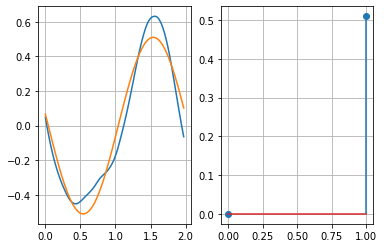

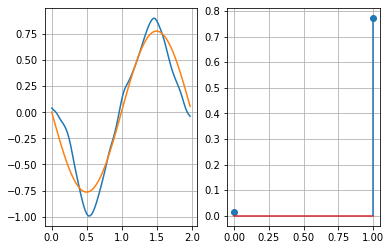

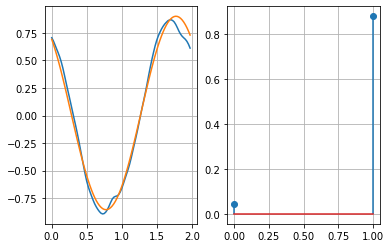

In [156]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

#### Percebemos graficamente que não conseguimos reconstruir o sinal com boa precisão, consequentemente o som se torna bem diferente do original. Vamos agora verificar para o dobro de harmônicas, ou seja, 2 harmônicas.

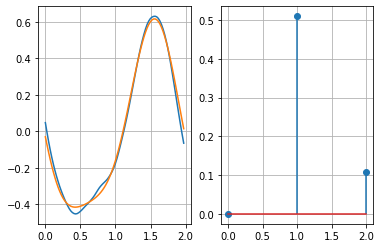

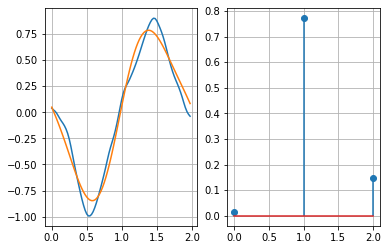

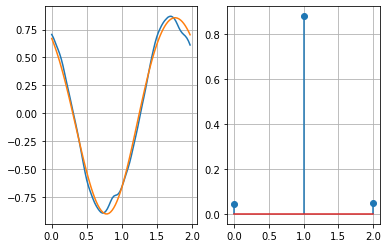

In [157]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

#### Podemos perceber que ja temos uma precisão maior na reconstrução do sinal, mas ainda não é uma reconstrução rica em detalhes, como por exemplo o segundo sinal, ele perde detalhes essenciais na sua reprodução, principalmente nas suas oscilações mais intensas, como podemos perceber graficamente. Vamos agora verificar com o número de 5 harmônicas

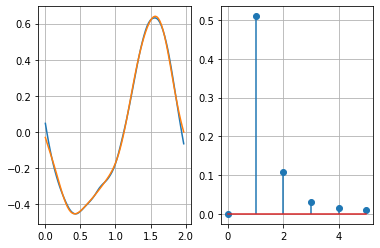

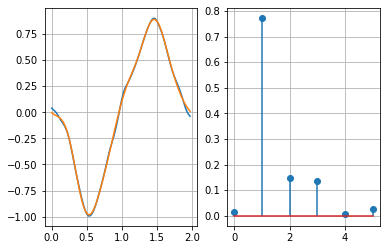

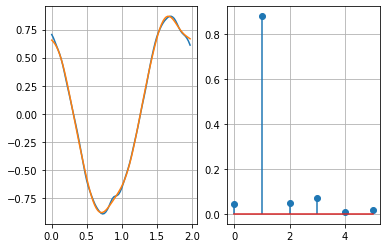

In [158]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 5)

#### Vemos que agora o sinal ja foi bem reconstruido e se aproxima muito do original, porém, por exemplo no primeiro sinal, no começo e no fim dele, temos uma diferença que pode ser verificada graficamente e para quem tem um bom "ouvido" escutando o som também da para perceber. Vamos agora crescendo esse número de harmônicas e percebendo o que vai acontecendo.

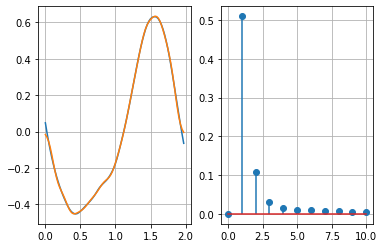

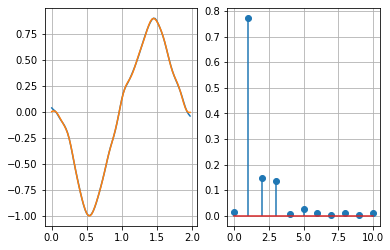

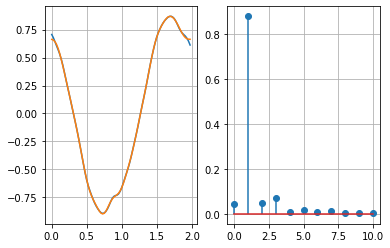

In [159]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

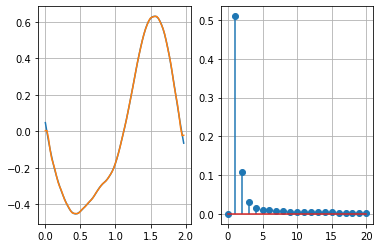

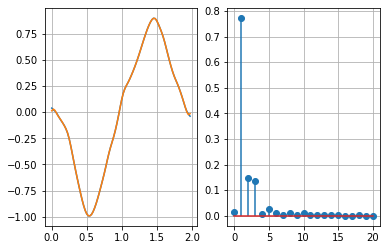

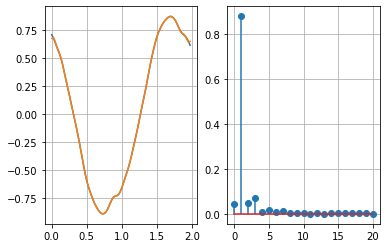

In [160]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 20)

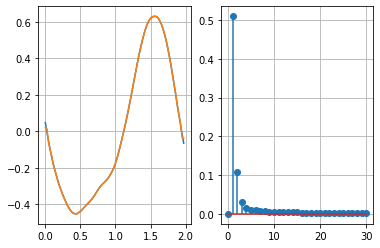

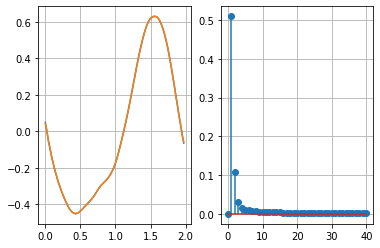

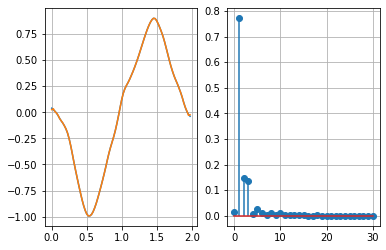

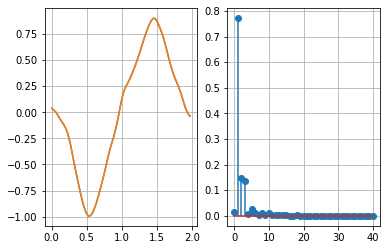

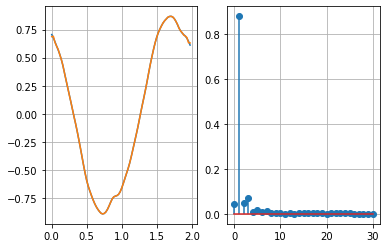

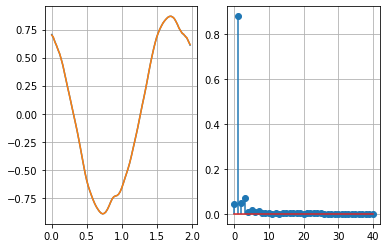

In [161]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 30)
    approximateUpToNthHarmonic(P, R, 40)

#### Logo, percebe que ao chegar em 40 harmônicas, nosso sinal ja é reconstruído com bastante precisão, se diferenciando muito pouco do som original, uma diferença que é imperceptível ao ouvido humano e podemos observar bem isso nos gráificos ilustrados para cada sinal e cada harmônica que foi reconstruída.

#### O objetivo agora é reconstruir uma onda quadrada com série de Fourier. Neste primeiro momento vamos gerar uma onda quadrada e vê como ela soa.

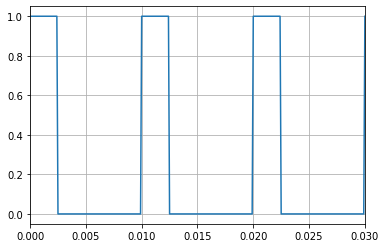

In [162]:
Fs = 10000
F = 100
N = Fs/F
T=1
period = (np.arange(N) < (N/4)).astype(float)
t = np.arange(0, T, 1/Fs)
signal = np.tile(period, T*F)
plt.xlim(right=0.03)
plt.plot(t, signal)
plt.grid(True)
Audio(data=signal, rate=Fs)

#### Ela soa um pouco desconfortável, quase como a gente tem um cabo de guitarra ou microfone com problemas, porém da para escutar as frequencias baixas e altas do sinal. Vamos agora, fazer o mesmo procedimento que fizemos para os áudios das falutas e ir reconstruindo o sinal a partir de 1, 3, 5, 11, 21 e finalmente 49 harmônicas e ver seu comportamento grafico e auditivo.

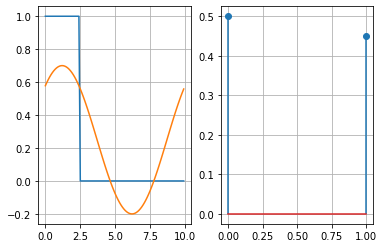

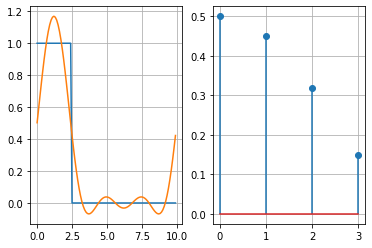

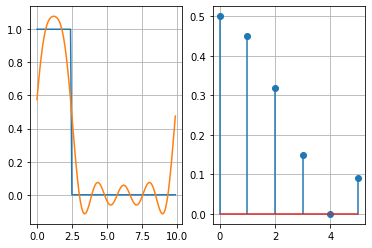

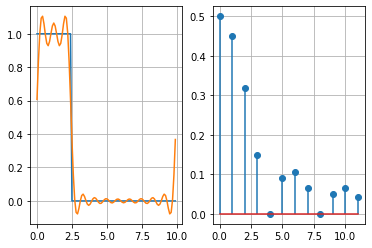

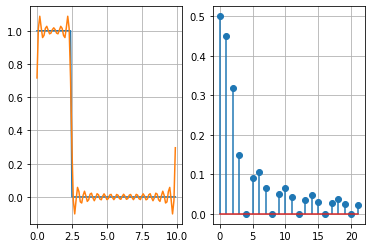

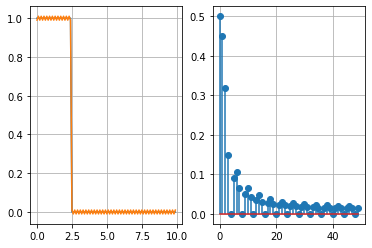

In [163]:
for N in [1, 3, 5, 11, 21, 49]:
    approximateUpToNthHarmonic(period, Fs, N)

#### Assim como os sons da flautas, mesma situação ocorre para uma onda quadrada, precisamos de muitas harmônicas para construir o sinal com precisão, se observarmos o gráfico com 21 harmônicas (um número ja considerável) percebemos que o sinal ainda possui muita diferença do sinal original, mas quando aumentamos isso para mais que o dobro (49 harmônicas) o sinal ja se aproxima bastante do original. Portanto, percebemos que quanto mais harmônicas utilizarmos para a reconstrução do sinal, mais vamos ter uma maior precisão neste trabalho.

### TAREFA 2: Reproduzir os resultados dos 16 exemplos mostrados no texto em anexo, discutindo se o resultado computacional equivale ao analítico mostrado no exemplo.

#### Definição da função ft para aproximação da transformada de Fourier, do FS relativa a Frequencia que vamos usar para a simulação do tempo inicial t0, do intervalo de tempo t e das amostras de frequência f tudo de acordo com o artigo <a href='https://dspillustrations.com/pages/posts/misc/the-sound-of-harmonics-approximating-instrument-sounds-with-fourier-series.html'>deste link</a>

In [164]:
Fs = 10
t0 = 5
t = np.arange(-t0, t0, 1/Fs)
f = np.arange(-Fs/2, Fs/2, Fs/len(t))

def ft(samples, Fs, t0):
    f = np.linspace(-Fs/2, Fs/2, len(samples), endpoint=False)
    return np.fft.fftshift(np.fft.fft(samples)/Fs * np.exp(-2j*np.pi*f*t0))

#### Exemplo 8.1:  Cálculo da transformada de Fourier do sinal  $$x(t) = e^{-at}.u_1(t), a > 0$$

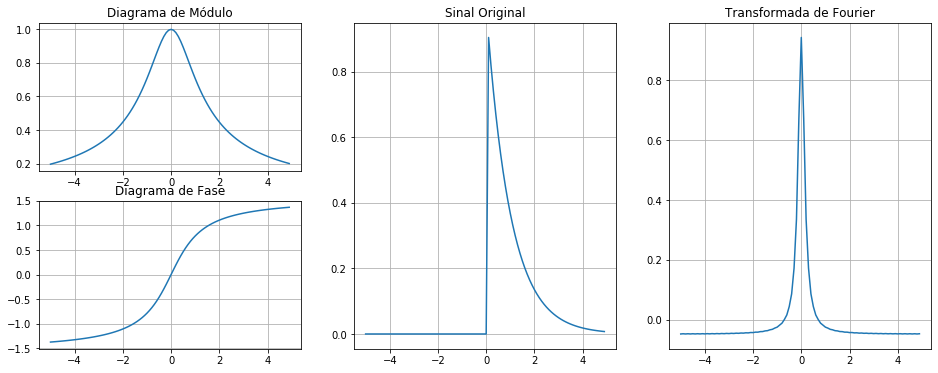

In [165]:
f1 = lambda t: np.exp(-a*t) * np.heaviside(t, 1)
f1_modulo = lambda w: 1 / np.sqrt(a**2 + w**2)
f1_fase = lambda w: np.arctan(w/a)
a = 1

plt.figure(figsize=(16, 6))
plt.subplot(132)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f1(t))

plt.subplot(231)
plt.grid(True)
plt.title("Diagrama de Módulo")
plt.plot(f, f1_modulo(t))

plt.subplot(234)
plt.grid(True)
plt.title("Diagrama de Fase")
plt.plot(f, f1_fase(t))

plt.subplot(133)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f1(t), Fs, t0).real)

#### Exemplo 8.2:  Cálculo da transformada de Fourier do sinal  $$x(t) = e^{-a|t|}, a > 0$$

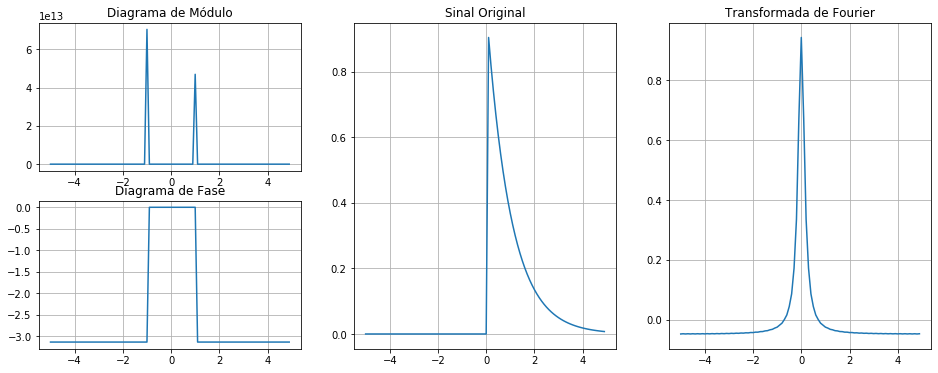

In [166]:
f2 = lambda t: np.exp(-a*np.abs(t)) * np.heaviside(t, 1)
f2_modulo = lambda w: (2*a) / np.abs((a**2 - w**2))
def f2_fase(t):
    result = []
    for i in t:
        if(i < -a or i > a):
            result.append(-np.pi)
        else:
            result.append(0)
    return result

a = 1

plt.figure(figsize=(16, 6))
plt.subplot(132)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f2(t))

plt.subplot(231)
plt.grid(True)
plt.title("Diagrama de Módulo")
plt.plot(f, f2_modulo(t))

plt.subplot(234)
plt.grid(True)
plt.title("Diagrama de Fase")
plt.plot(f, f2_fase(t))

plt.subplot(133)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f2(t), Fs, t0).real)

#### Exemplo 8.3:  Cálculo da transformada de Fourier do sinal  $$x(t) = \left \{ \begin{matrix} 1, & \mbox{se }n\mbox{ |t| < a} \\ 0, & \mbox{se }n\mbox{ |t|> a} \end{matrix} \right.$$

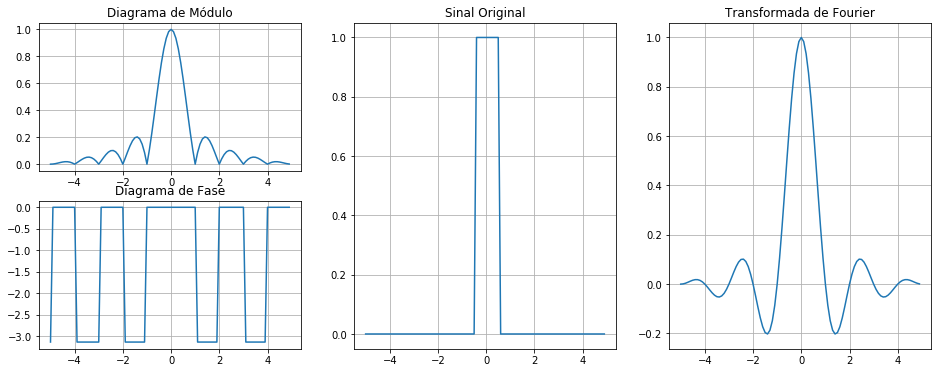

In [167]:
f3_fase = lambda w: -np.pi * ((ft(f3(w), Fs, t0).real) < 0)
def f3(t): # considera-se a = 0.5
    a = 0.5
    return 1*(np.abs(t) < a)

plt.figure(figsize=(16, 6))
plt.subplot(132)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f3(t))

plt.subplot(231)
plt.grid(True)
plt.title("Diagrama de Módulo")
plt.plot(f, np.abs(ft(f3(t), Fs, t0).real))

plt.subplot(234)
plt.grid(True)
plt.title("Diagrama de Fase")
plt.plot(f, f3_fase(t))

plt.subplot(133)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f3(t), Fs, t0).real)

#### Exemplo 8.4:  Cálculo da transformada de Fourier do sinal  $$x(t) = sen(\omega_0t)$$

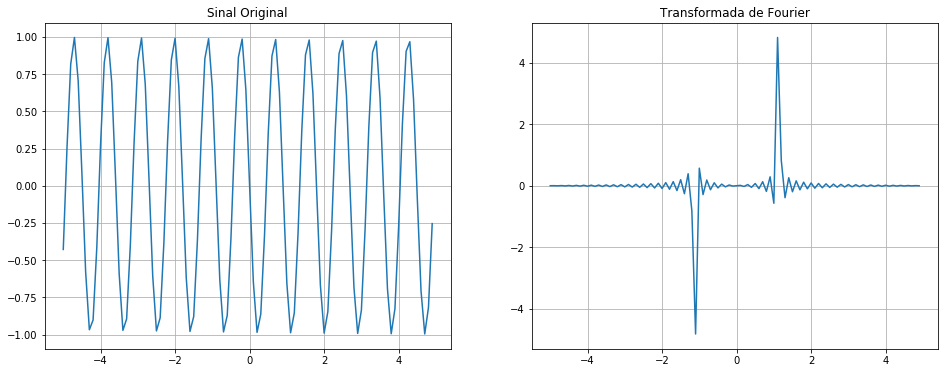

In [168]:
f4 = lambda t: np.sin(w*t)
w = -7

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f4(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f4(t), Fs, t0).imag)

#### Exemplo 8.5:  Cálculo da transformada de Fourier do sinal  $$x(t) = cos(\omega_0t)$$

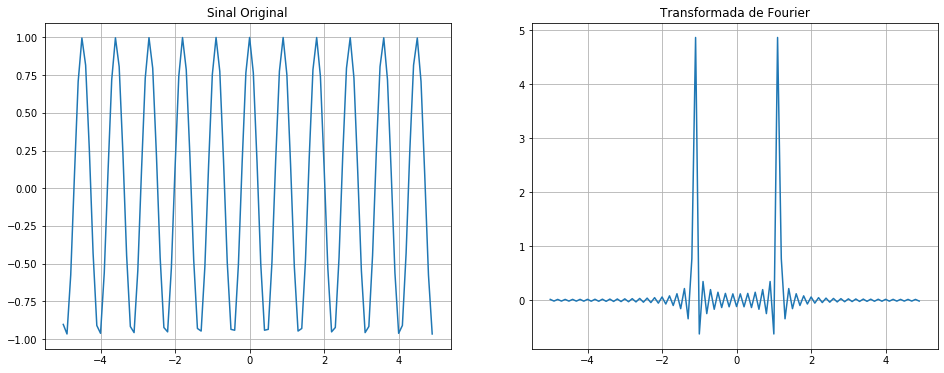

In [169]:
f5 = lambda t: np.cos(w*t)
w = 7

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f5(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f5(t), Fs, t0).real)

#### Exemplo 8.6:  Cálculo da transformada de Fourier do sinal  $$x(t) = \left \{ \begin{matrix} -1, & \mbox{se } \mbox{ -1 < t < 0} \\ 1, & \mbox{se } \mbox{ 0 < t < 1} \end{matrix} \right.$$

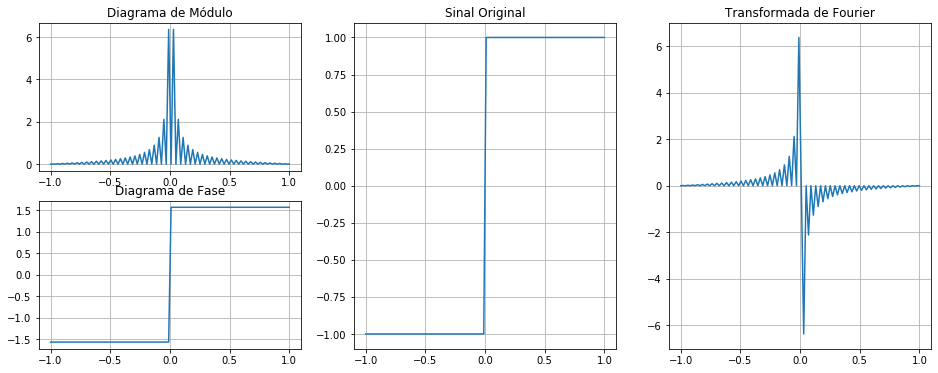

In [170]:
t_6 = np.linspace(-1, 1, 100)
def f6(t):
    values = []
    for i in t:
        if(-1 <= i <= 0):
            values.append(-1)
        elif(0 < i <= 1):
            values.append(1)
    
    return values

def f6_fase(t):
    values = []
    for i in t:
        if(i < 0):
            values.append(-np.pi/2)
        elif(i > 0):
            values.append(np.pi/2)
        else:
            values.append(0)
            
    return values

plt.figure(figsize=(16, 6))
plt.subplot(132)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t_6, f6(t_6))

plt.subplot(231)
plt.grid(True)
plt.title("Diagrama de Módulo")
plt.plot(t_6, np.abs(ft(f6(t_6), Fs, t0).imag))

plt.subplot(234)
plt.grid(True)
plt.title("Diagrama de Fase")
plt.plot(t_6, f6_fase(t_6))

plt.subplot(133)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(t_6, ft(f6(t_6), Fs, t0).imag)

#### Exemplo 8.7:  Cálculo da transformada de Fourier do sinal  $$x(t) = \left \{ \begin{matrix} 1, & \mbox{se } \mbox{|t| < a} \\ 0, & \mbox{se } \mbox{ a < |t| < T/2} \end{matrix} \right.$$

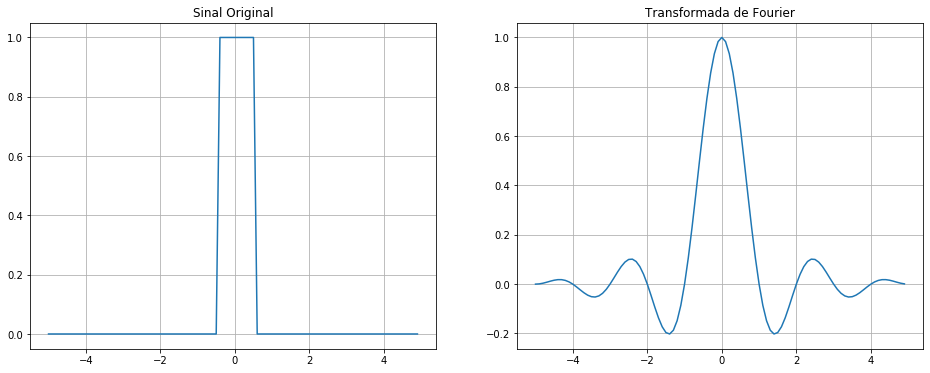

In [171]:
def f7(t):
    values = []
    for i in t:
        if(np.abs(i) < a):
            values.append(1)
        else:
            values.append(0)
            
    return values
    
a = 0.5
T = 4

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f7(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(t, ft(f7(t), Fs, t0).real)

#### Exemplo 8.8:  Cálculo da transformada de Fourier do sinal  descrito pelo gráfico da Fig.8.20 do PDF

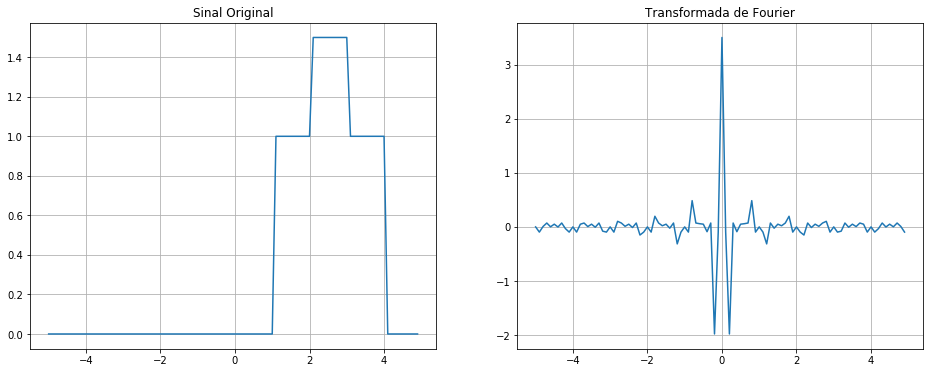

In [172]:
f8 = lambda t: np.heaviside(t-1, 1) + (0.5*np.heaviside(t-2, 1) - 0.5*np.heaviside(t-3, 1)) - np.heaviside(t-4, 1)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f8(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f8(t), Fs, t0).real)

#### Exemplo 8.9:  Cálculo da transformada de Fourier do sinal  $$x(t) = e^{-a|t|}, a > 0$$

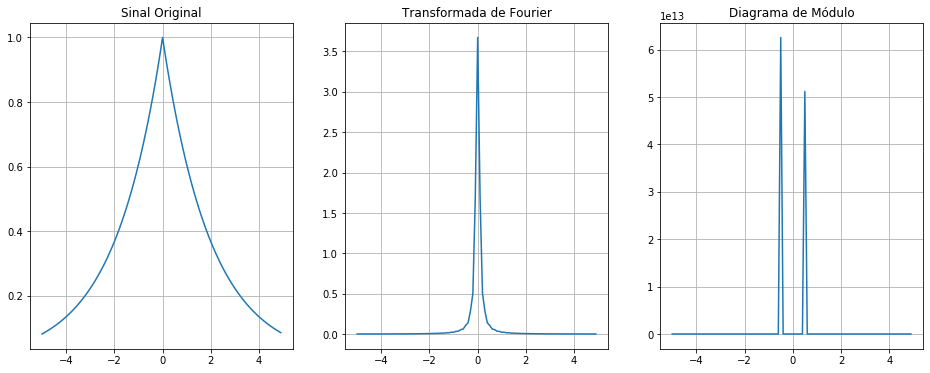

In [173]:
f9 = lambda t: np.exp(-a*np.abs(t)) * (a > 0)
f9_modulo = lambda w: (2*a) / np.abs((a**2 - w**2))
a = 0.5

plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f9(t))

plt.subplot(132)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f9(t), Fs, t0).real)

plt.subplot(133)
plt.grid(True)
plt.title("Diagrama de Módulo")
plt.plot(f, f9_modulo(t))

 #### Exemplo 8.10:  Cálculo da transformada de Fourier do sinal  $x(t) = u_0(t)$ (impulso unitário)

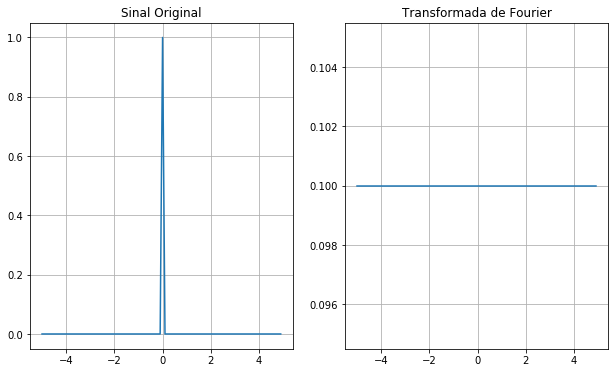

In [174]:
def f10(t):
    values = []
    for i in t:
        if round(i, 1) == 0.0:
            values.append(1)
        else:
            values.append(0)
    return values

plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f10(t))

plt.subplot(132)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f10(t), Fs, t0).real)

 #### Exemplo 8.11:  Cálculo da transformada de Fourier do sinal  $x(t) = u_1(t)$ (degrau unitário) //TIRAR DÚVIDA

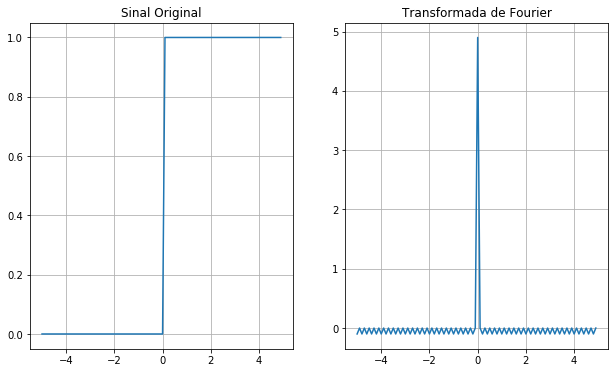

In [175]:
def f11(t):
    values = []
    for i in t:
        if i > 0:
            values.append(1)
        else:
            values.append(0)
    return values

plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f11(t))

plt.subplot(132)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f11(t), Fs, t0).real)

 #### Exemplo 8.12:  Cálculo da transformada de Fourier do sinal  $f(t) = e^{-|t|}$

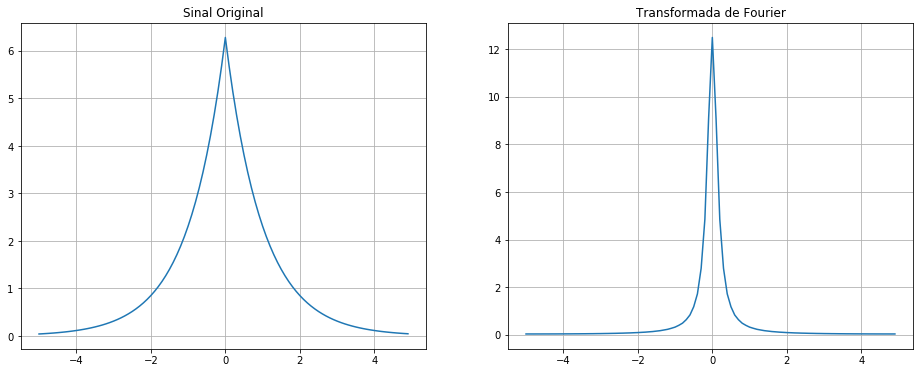

In [176]:
f12 = lambda t: 2*np.pi * np.exp(-np.abs(t))

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f12(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f12(t), Fs, t0).real)

#### Exemplo 8.13: Considere o sistema SLIT onde a resposta ao impulso é dada por $$h(t) = u_0(t - t_0)$$ Usando a propriedade dual do “time shifting” para a transformada de Fourier, obtemos a resposta no domínio da frequência, a transformada de Fourier de h(t)

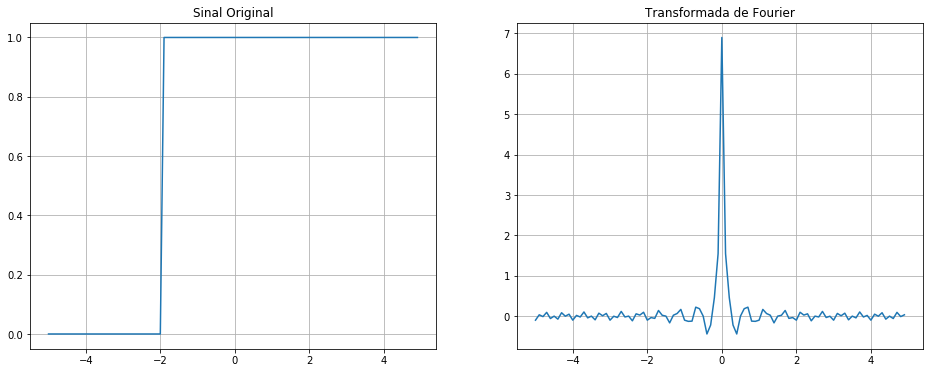

In [177]:
f13 = lambda t: np.heaviside(t - t_0, 1)
t_0 = -2

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f13(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(f, ft(f13(t), Fs, t0).real)

#### Exemplo 8.14: Explicação da propriedade da transformada para um sistema diferenciador

#### Exemplo 8.15: Explicação da propriedade da transformada para um sistema integrador

#### Exemplo 8.16: Cálculo de h(t) para o filtro passa-baixa ideal $$x(t) = \left \{ \begin{matrix} 1, & \mbox{se } \mbox{|w| < wc} \\ 0, & \mbox{se } \mbox{ |w| > wc} \end{matrix} \right.$$

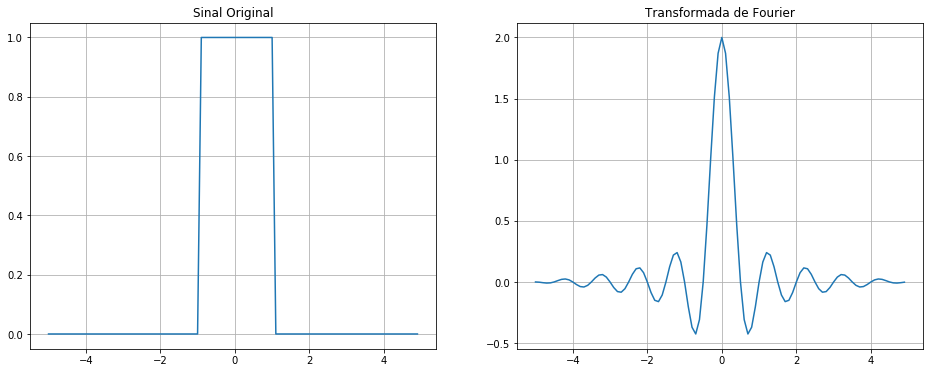

In [178]:
f16 = lambda w: 1 * np.abs(w) < w_c
w_c = 1

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.grid(True)
plt.title("Sinal Original")
plt.plot(t, f16(t))

plt.subplot(122)
plt.grid(True)
plt.title("Transformada de Fourier")
plt.plot(t, ft(f16(t), Fs, t0).real)